In [ ]:
!pip install fsspec
!pip install gcsfs
!pip install transformers -q

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 12.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 19.2 MB/s 
     |████████████████████████████████| 144 kB 42.4 MB/s 
     |████████████████████████████████| 94 kB 1.0 MB/s 
     |████████████████████████████████| 271 kB 49.3 MB/s 
     |████████████████████████████████| 4.4 MB 14.0 MB/s 
     |████████████████████████████████| 6.6 MB 12.2 MB/s 
     |████████████████████████████████| 101 kB 12.9 MB/s 
     |████████████████████████████████| 596 kB 75.2 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s "/content/drive/My Drive/Colab Notebooks/tfm"
import sys
sys.path.append('tfm/checkpoints/')
sys.path.append('tfm/outputs/')

Mounted at /content/drive


In [ ]:
import json
from dataclasses import dataclass, field
from typing import Optional

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
from scipy.special import softmax
from sklearn.metrics import (
    auc,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    precision_recall_curve,
    roc_auc_score,
)
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    BertConfig,
    BertTokenizer,
    EvalPrediction,
    Trainer,
)
from transformers.training_args import TrainingArguments
from tqdm import tqdm

In [ ]:
filepath = "tfm/outputs/dataset_2021_paragraph" # Filepath COLAB
filepath_news = "tfm/outputs/dataset_2021_news" # Filepath COLAB

In [ ]:
labeled_df = pd.read_csv(f"{filepath}_filters.csv", sep=";", index_col=0, parse_dates=["date"],low_memory=False, lineterminator="\n")
# labeled_df = pd.read_csv(f"{filepath}_predict_impacto_finanzas_tag_s_n.csv", sep=";", index_col=0, parse_dates=["date"])
# labeled_df = pd.read_csv(f"{filepath_news}_predict_impacto_finanzas_tag_s_n.csv", sep=";", index_col=0, parse_dates=["date"])
labeled_df.shape

(42285, 53)

In [ ]:
labeled_df.dtypes

pk_paragraph                          object
date                          datetime64[ns]
title                                 object
url                                   object
body                                  object
tags                                  object
resource                              object
ticker                                object
ticker_name                           object
sector                                object
subsector                             object
ticker_freq                            int64
ticker_first                         float64
ticker_title                         float64
tickers                               object
entities                              object
topic_classifier                      object
topics                                object
finanzas_prob                        float64
sector_in_topics                       int64
intensidad                           float64
rd_activo_news                       float64
rd_bench_n

In [ ]:
labeled_df.sort_values(by=["date", "pk_paragraph"], inplace=True)

In [ ]:
labeled_df.vola_label.value_counts()/labeled_df.vola_label.count()

 1.0    0.400591
-1.0    0.306397
 0.0    0.293012
Name: vola_label, dtype: float64

In [ ]:
# Se excluye topic_classifier debido al gran número de etiquetas:
labeled_df.topic_classifier.unique().shape

(585,)

In [ ]:
exclude_cols = ['pk_paragraph',
                'title',
                'title_no_entities',
                'url',
                'body',
                'tags',
                'resource',
                'ticker',
                'ticker_name',
                'subsector',
                'tickers',
                'entities',
                'topics',
                'topic_classifier',
                'rd_activo_news',
                'rd_bench_news',
                'vola20_expost',
                'vola20_antepost_pct_change',
                'vola20_umbral_Q1',
                'vola20_umbral_abs_Q1',
                'vola20_umbral_Q3',
                'vola20_umbral_abs_Q3',
                'topic_classifier_news',
                'topics_news',
                'finanzas_prob_news',
                'impacto_tag_news_s_n',
                'sector_in_topics_news',
                'intensidad_news',
                'finanzas_tag_news_s_n',
                #'finanzas_tag_s_proba',
                #'impacto_tag_s_proba',
                # 'topic_tag_news_proba',

                # 'ticker_freq'          , 
                # 'ticker_first'          ,
                # 'ticker_title'          ,
                 'finanzas_prob'         ,
                # 'sector_in_topics'      ,
                'intensidad'            ,
                'alpha_exante'          ,
                'alpha_exante_Q1'       ,
                'alpha_exante_below_Q1' ,
                'alpha_exante_Q3'       ,
                'alpha_exante_above_Q3' ,

                #'finanzas_tag_s_n'            ,
                #'impacto_tag_s_n'             ,
                'topic_tag_news'              ,
                'impacto_tag_s_n_confianza'   ,
                'finanzas_tag_s_n_confianza'  ,

                'vola_label_abs'                       

                ]

In [ ]:
print(labeled_df.shape)
labeled_df.drop(columns=exclude_cols, axis=1, inplace=True)
print(labeled_df.shape)
labeled_df.dropna(inplace=True)
print(labeled_df.shape)

(42285, 53)
(42285, 13)
(42285, 13)


In [ ]:
labeled_df.dtypes

date                    datetime64[ns]
sector                          object
ticker_freq                      int64
ticker_first                   float64
ticker_title                   float64
sector_in_topics                 int64
vola20_exante                  float64
vola_label                     float64
body_no_entities                object
finanzas_tag_s_n                 int64
impacto_tag_s_n                  int64
impacto_tag_s_proba            float64
finanzas_tag_s_proba           float64
dtype: object

In [ ]:
topics_equivalence = {
                    1:'Gobierno Corporativo +',
                    2:'Gobierno Corporativo -',
                    3:'Reporte Beneficios +',
                    4:'Reporte Beneficios -',
                    5:'Financiero +',
                    6:'Financiero -',
                    7:'General +',
                    8:'General -',
                    9:'Legal +',
                    10:'Legal -',
                    11:'Operacional +',
                    12:'Operacional -',
                    13:'Restructuración +',
                    14:'Restructuración -'
                    }

In [ ]:
convert_types = {
                "sector": "object",
                "ticker_freq": "uint16",
                "ticker_first":"bool",
                "ticker_title":"bool",
                # "finanzas_prob":"float64",
                "sector_in_topics":"bool",
                # "intensidad":"float64",
                # "alpha_exante":"float64",
                # "alpha_exante_Q1":"float64",
                # "alpha_exante_below_Q1":"bool",
                # "alpha_exante_Q3":"float64",
                # "alpha_exante_above_Q3":"bool",
                "vola20_exante":"float64",
                "vola_label":"int8",
                # "vola_label_abs":"int8",
                # "title_no_entities":"object",
                "body_no_entities":"object",
                # "topic_tag_news":"object",
                "finanzas_tag_s_n":"bool",
                "impacto_tag_s_n":"bool",
                "finanzas_tag_s_proba":"float64",
                "impacto_tag_s_proba":"float64",
                }

In [ ]:
to_standardize = [
                  "ticker_freq",
                  # "intensidad",
                  # "alpha_exante",
                  # "alpha_exante_Q1",
                  # "alpha_exante_Q3",
                  "vola20_exante",
                ]

In [ ]:
labeled_df = labeled_df.astype(convert_types)

In [ ]:
# Generando las las dummies:
labeled_df = pd.get_dummies(labeled_df, columns=["sector"], drop_first=True, dtype="bool")

In [ ]:
labeled_df.vola_label = labeled_df.vola_label + 1

In [ ]:
labeled_df.dtypes

date                                            datetime64[ns]
ticker_freq                                             uint16
ticker_first                                              bool
ticker_title                                              bool
sector_in_topics                                          bool
vola20_exante                                          float64
vola_label                                                int8
body_no_entities                                        object
finanzas_tag_s_n                                          bool
impacto_tag_s_n                                           bool
impacto_tag_s_proba                                    float64
finanzas_tag_s_proba                                   float64
sector_Mat.Basicos, Industria y Construcción              bool
sector_Petróleo y Energía                                 bool
sector_Servicios Financieros                              bool
sector_Servicios Inmobiliarios                         

In [ ]:
features = labeled_df.copy()

In [ ]:
# Separando los datos de train con los de validación y test con un mes de tiempo
threshold_train = int(labeled_df.shape[0]*0.8)
paragraphs_month = labeled_df.resample("M", on="date").body_no_entities.count()
labeled_df.drop("date", axis=1, inplace=True)
mask = paragraphs_month.cumsum() < threshold_train
train_split = paragraphs_month.cumsum()[mask][-1]
val_split = paragraphs_month.cumsum()[~mask][0]
test_split = val_split + int((labeled_df.shape[0]-val_split)/2)
train = labeled_df.iloc[:train_split]
val = labeled_df.iloc[val_split:test_split]
test = labeled_df.iloc[test_split:]

In [ ]:
ss = StandardScaler()

In [ ]:
train[to_standardize] = ss.fit_transform(train[to_standardize])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
val[to_standardize] = ss.transform(val[to_standardize])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
test[to_standardize] = ss.transform(test[to_standardize])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
class CustomModel(torch.nn.Module):

    def __init__(self, model_name, num_extra_dims, num_labels):

        super().__init__()

        self.config = AutoConfig.from_pretrained(model_name)
        self.transformer = AutoModel.from_pretrained(model_name, config=self.config)
        num_hidden_size = self.transformer.config.hidden_size
        self.classifier = torch.nn.Linear(num_hidden_size+num_extra_dims, num_labels)


    def forward(self, input_ids, extra_data, attention_mask=None):

        hidden_states = self.transformer(input_ids=input_ids, attention_mask=attention_mask)

        cls_embeds = hidden_states.last_hidden_state[:, 0, :]

        concat = torch.cat((cls_embeds, extra_data), dim=-1)

        classif = self.classifier(concat)

        output = torch.nn.Softmax(dim=1)(classif)

        return output

In [ ]:
model_name = "dccuchile/bert-base-spanish-wwm-uncased"
# num_extra_dims = 20
num_extra_dims = 15
num_labels = 3
batch_size = 20

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = AutoTokenizer.from_pretrained(model_name)
custom_model = CustomModel(model_name, num_extra_dims=num_extra_dims, num_labels=num_labels).to(device)

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dens

In [ ]:
class MyDataset(Dataset):
 
  def __init__(self, pd_dataframe):
 
    x=pd_dataframe.drop(columns=["vola_label", "body_no_entities"]).astype("float64").values
    y=pd_dataframe[["vola_label"]].values
 
    self.x_train=torch.tensor(x, dtype=torch.float32)
    self.y_train=torch.tensor(y, dtype=torch.float32)
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [ ]:
train.drop(columns=["vola_label", "body_no_entities"]).astype("float64").values.shape
train_ds = MyDataset(train)
train_loader=DataLoader(train_ds, batch_size=10, shuffle=False)
encoded = tokenizer(train.body_no_entities.to_list(), padding="max_length", truncation=True, return_tensors="pt")
train_input_ids = DataLoader(encoded["input_ids"], batch_size=10, shuffle=False)
train_attention_mask = DataLoader(encoded["attention_mask"], batch_size=10, shuffle=False)

In [ ]:
val.drop(columns=["vola_label", "body_no_entities"]).astype("float64").values.shape
val_ds = MyDataset(val)
val_loader=DataLoader(val_ds, batch_size=10, shuffle=False)
encoded_val = tokenizer(val.body_no_entities.to_list(), padding="max_length", truncation=True, return_tensors="pt")
val_input_ids = DataLoader(encoded_val["input_ids"], batch_size=10, shuffle=False)
val_attention_mask = DataLoader(encoded_val["attention_mask"], batch_size=10, shuffle=False)

In [ ]:
test.drop(columns=["vola_label", "body_no_entities"]).astype("float64").values.shape
test_ds = MyDataset(test)
test_loader=DataLoader(test_ds, batch_size=10, shuffle=False)
encoded_test = tokenizer(test.body_no_entities.to_list(), padding="max_length", truncation=True, return_tensors="pt")
test_input_ids = DataLoader(encoded_test["input_ids"], batch_size=10, shuffle=False)
test_attention_mask = DataLoader(encoded_test["attention_mask"], batch_size=10, shuffle=False)

In [ ]:
########## Guarda los mejores checkpoints por val_loss y EarlyStopping aplicado a val_loss ##########

n_epochs = 12
print_every = 250
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
early_stopping = True
patience_epochs = 2
patience_count = 0

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(custom_model.parameters(), lr=2e-5, weight_decay=0.01)

for epoch in tqdm(range(1, n_epochs+1)):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    with tqdm(total=total_step, position=0, leave=True) as pbar:
        for batch_idx, data in enumerate(zip(train_input_ids, train_attention_mask, train_loader)):
            input_ids, attention_masks, extra_data = data
            input_ids = input_ids.to(device)
            attention_masks = attention_masks.to(device)
            extra_data_feat, extra_data_labels = extra_data
            extra_data_feat = extra_data_feat.to(device)
            extra_data_labels = extra_data_labels.type(torch.LongTensor)
            extra_data_labels = extra_data_labels[:,0].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = custom_model(input_ids, extra_data_feat, attention_mask=attention_masks)
            loss = criterion(outputs, extra_data_labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
            _,pred = torch.max(outputs, dim=1)
            correct += torch.sum(pred==extra_data_labels).item()
            total += extra_data_labels.size(0)
            if (batch_idx) % print_every == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
            pbar.update()
    train_acc.append(correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        custom_model.eval()
        for data_val in zip(val_input_ids, val_attention_mask, val_loader):
            input_ids_val, attention_masks_val, extra_data_val = data_val
            input_ids_val = input_ids_val.to(device)
            attention_masks_val = attention_masks_val.to(device)
            extra_data_feat_val, extra_data_labels_val = extra_data_val
            extra_data_feat_val = extra_data_feat_val.to(device)
            extra_data_labels_val = extra_data_labels_val.type(torch.LongTensor)
            extra_data_labels_val = extra_data_labels_val[:,0].to(device)
            outputs_val = custom_model(input_ids_val, extra_data_feat_val, attention_mask=attention_masks_val)
            loss_t = criterion(outputs_val, extra_data_labels_val)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_val, dim=1)
            correct_t += torch.sum(pred_t==extra_data_labels_val).item()
            total_t += extra_data_labels_val.size(0)
        val_acc.append(correct_t / total_t)
        val_loss.append(batch_loss/len(val_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(custom_model.state_dict(), 'vola_paragraph_pytorch.pt')
            print('Detected network improvement, saving current model')
            patience_count = 0
        else:
            patience_count += 1
            if patience_count >= patience_epochs and early_stopping:
                break
    custom_model.train()

Epoch 1

Epoch [1/12], Step [0/3198], Loss: 0.5592
Epoch [1/12], Step [20/3198], Loss: 0.8516
Epoch [1/12], Step [40/3198], Loss: 0.9512
Epoch [1/12], Step [60/3198], Loss: 0.5528
Epoch [1/12], Step [80/3198], Loss: 0.5529
Epoch [1/12], Step [100/3198], Loss: 1.3190
Epoch [1/12], Step [120/3198], Loss: 0.6870
Epoch [1/12], Step [140/3198], Loss: 1.5490
Epoch [1/12], Step [160/3198], Loss: 0.5537
Epoch [1/12], Step [180/3198], Loss: 0.7534
Epoch [1/12], Step [200/3198], Loss: 1.5351
Epoch [1/12], Step [220/3198], Loss: 1.4923
Epoch [1/12], Step [240/3198], Loss: 1.3436
Epoch [1/12], Step [260/3198], Loss: 1.5412
Epoch [1/12], Step [280/3198], Loss: 0.6411
Epoch [1/12], Step [300/3198], Loss: 1.4610
Epoch [1/12], Step [320/3198], Loss: 1.0395
Epoch [1/12], Step [340/3198], Loss: 1.0576
Epoch [1/12], Step [360/3198], Loss: 1.3940
Epoch [1/12], Step [380/3198], Loss: 1.3127
Epoch [1/12], Step [400/3198], Loss: 1.2346
Epoch [1/12], Step [420/3198], Loss: 1.4092
Epoch [1/12], Step [440/3198]

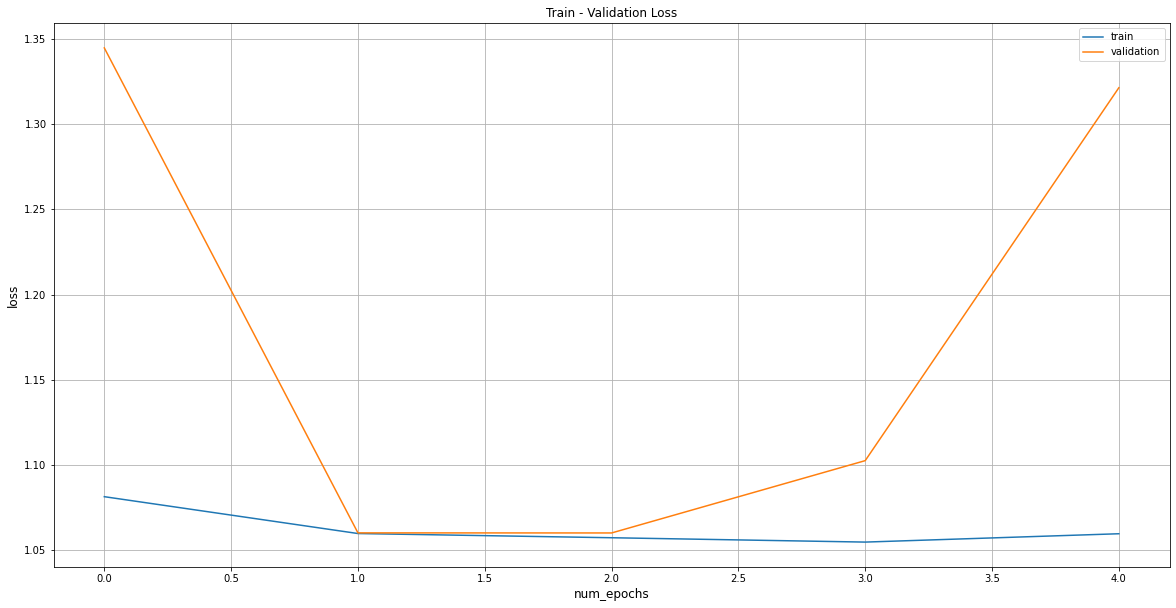

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()

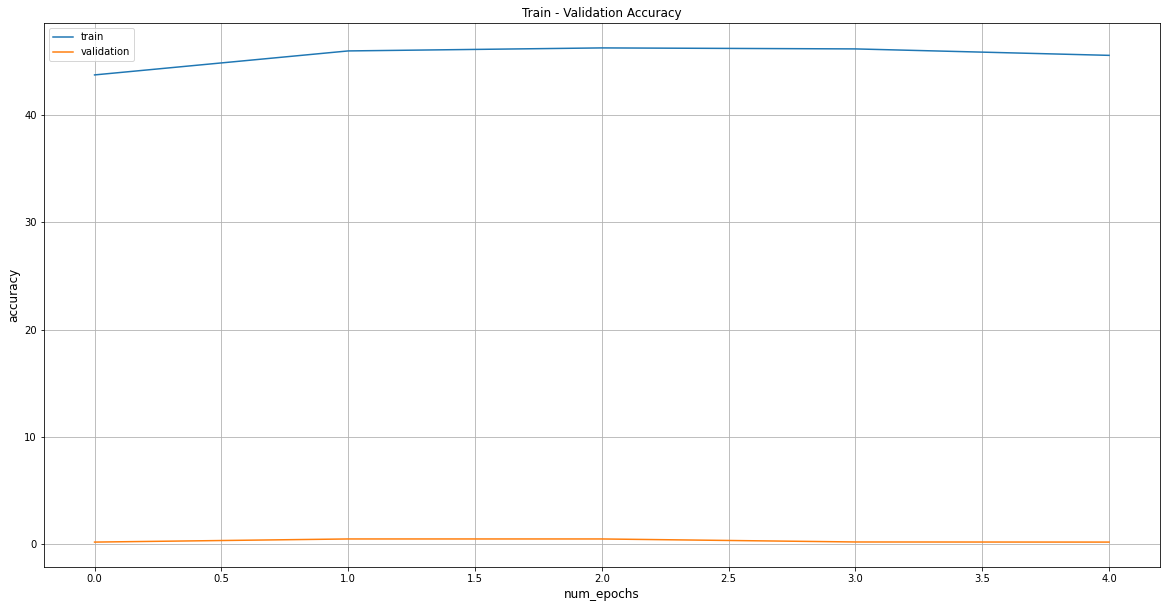

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid()
plt.show()

In [ ]:
with torch.no_grad():
    custom_model.eval()
    for data_test in zip(test_input_ids, test_attention_mask, test_loader):
        input_ids_test, attention_masks_test, extra_data_test = data_test
        input_ids_test = input_ids_test.to(device)
        attention_masks_test = attention_masks_test.to(device)
        extra_data_feat_test, extra_data_labels_test = extra_data_test
        extra_data_feat_test = extra_data_feat_test.to(device)
        extra_data_labels_test = extra_data_labels_test.type(torch.LongTensor)
        extra_data_labels_test = extra_data_labels_test[:,0].to(device)
        outputs_test = custom_model(input_ids_test, extra_data_feat_test, attention_mask=attention_masks_test)
        loss_t = criterion(outputs_test, extra_data_labels_test)
        batch_loss += loss_t.item()
        _,pred_t = torch.max(outputs_test, dim=1)
        correct_t += torch.sum(pred_t==extra_data_labels_test).item()
        total_t += extra_data_labels_test.size(0)
    test_acc = correct_t / total_t
    print("test acc:", test_acc)

test acc: 0.3173982326524699


In [ ]:
custom_model.load_state_dict(torch.load('vola_paragraph_pytorch.pt'))

<All keys matched successfully>

# FOLDS TIME SERIES SPLIT

In [ ]:
features

,date,ticker_freq,ticker_first,ticker_title,sector_in_topics,vola20_exante,vola_label,body_no_entities,finanzas_tag_s_n,impacto_tag_s_n,impacto_tag_s_proba,finanzas_tag_s_proba,"sector_Mat.Basicos, Industria y Construcción",sector_Petróleo y Energía,sector_Servicios Financieros,sector_Servicios Inmobiliarios,sector_Servicios de Consumo,sector_Tecnología y Telecomunicaciones
pk,,,,,,,,,,,,,,,,,,
1656287513236_43316_ANA,2021-01-01 02:06:52,1,True,False,False,0.330038,2,24 componentes en negativo,True,True,0.094076,0.027292,True,False,False,False,False,False
1656287513236_43316_ANA,2021-01-01 02:06:52,1,True,False,False,0.330038,2,El Ibex cierra un año negro con veinticuatro d...,True,True,0.448812,0.470685,True,False,False,False,False,False
1656287513236_43316_ANA,2021-01-01 02:06:52,1,True,False,False,0.330038,2,"El Dax, el único de la UE en positivo",True,True,0.092678,0.019101,True,False,False,False,False,False
1656287513236_43316_ANA,2021-01-01 02:06:52,1,True,False,False,0.330038,2,El parqué de Fráncfort fue el único europeo qu...,True,True,0.367660,0.283459,True,False,False,False,False,False
1656287513236_43316_ANA,2021-01-01 02:06:52,1,True,False,False,0.330038,2,"La banca, muy lastrada",True,True,0.131364,0.052694,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1656404116271_9_CABK,2022-03-11 17:25:00,3,False,True,False,0.522659,0,La acción se desarrolla en espacios emblemátic...,True,True,0.052462,0.005751,False,False,True,False,False,False
1656404116271_9_CABK,2022-03-11 17:25:00,3,False,True,False,0.522659,0,Igor Cortadellas ha sido el encargado de la di...,True,True,0.046825,0.004110,False,False,True,False,False,False
1656404116271_9_CABK,2022-03-11 17:25:00,3,False,True,False,0.522659,0,También ha contado con la producción musical d...,True,True,0.043305,0.004542,False,False,True,False,False,False


In [ ]:
features.reset_index(drop=True, inplace=True)
features.index = list(features.index)
features.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            42275, 42276, 42277, 42278, 42279, 42280, 42281, 42282, 42283,
            42284],
           dtype='int64', length=42285)

In [ ]:
features.resample(rule='M', on='date').size()

date
2021-01-31    3508
2021-02-28    3911
2021-03-31    3805
2021-04-30    3204
2021-05-31    4498
2021-06-30    3232
2021-07-31    3714
2021-08-31    3007
2021-09-30    3096
2021-10-31    3407
2021-11-30    3537
2021-12-31    3320
2022-01-31      35
2022-02-28       0
2022-03-31      11
Freq: M, dtype: int64

In [ ]:
features.resample(rule='M', on='date').size().iloc[1:-3]

date
2021-02-28    3911
2021-03-31    3805
2021-04-30    3204
2021-05-31    4498
2021-06-30    3232
2021-07-31    3714
2021-08-31    3007
2021-09-30    3096
2021-10-31    3407
2021-11-30    3537
2021-12-31    3320
Freq: M, dtype: int64

In [ ]:
np.mean(features.resample(rule='M', on='date').size().iloc[1:-3])

3521.0

In [ ]:
GAP = features.shape[0] / 12
int(GAP)

3523

In [ ]:
N_SPLITS = 8

In [ ]:
import os

indir = 'tfm/inputs'
for x in range(N_SPLITS+1):
  if not os.path.exists(f"{indir}/{x}"):
    os.mkdir(f"{indir}/{x}")

TimeSeriesSplit(gap=3523, max_train_size=None, n_splits=8, test_size=None)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

TRAIN dates: 2021-01-01 02:06:52 - 2021-01-11 13:38:46  TEST dates: 2021-02-13 23:30:00 - 2021-03-17 09:20:00
Epoch 1

Epoch [1/12], Step [0/95], Loss: 0.5525
Epoch [1/12], Step [20/95], Loss: 0.8514
Epoch [1/12], Step [40/95], Loss: 0.9514
Epoch [1/12], Step [60/95], Loss: 0.5517
Epoch [1/12], Step [80/95], Loss: 0.5518

train loss: 0.9482, train acc: 60.8280
validation loss: 1.1548, validation acc: 0.3959

Detected network improvement, saving current model
Epoch 2

Epoch [2/12], Step [0/95], Loss: 0.5544
Epoch [2/12], Step [20/95], Loss: 0.8514
Epoch [2/12], Step [40/95], Loss: 0.9512
Epoch [2/12], Step [60/95], Loss: 0.5521
Epoch [2/12], Step [80/95], Loss: 0.5523

train loss: 0.9483, train acc: 60.8280
validation loss: 1.1550, validation acc: 0.3959

Epoch 3

Epoch [3/12], Step [0/95], Loss: 0.5529
Epoch [3/12], Step [20/95], Loss: 0.8515
Epoch [3/12], Step [40/95], Loss: 0.9511
Epoch [3/12], Step [60/95], Loss: 0.5525
Epoch [3/12], Step [80/95], Loss: 0.5526

train loss: 0.9482, t

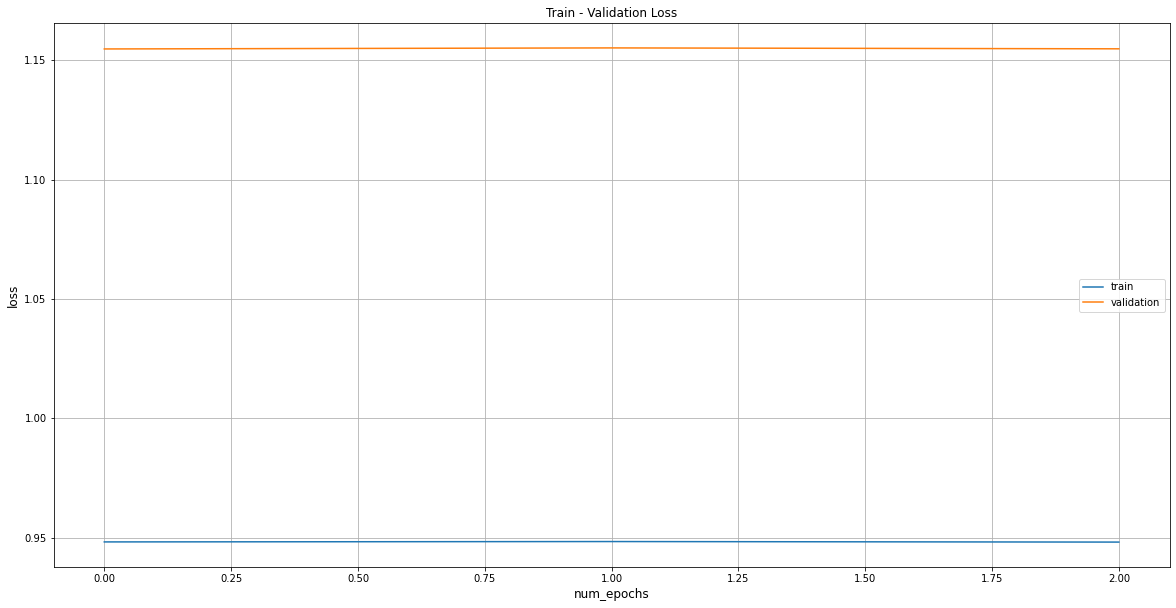

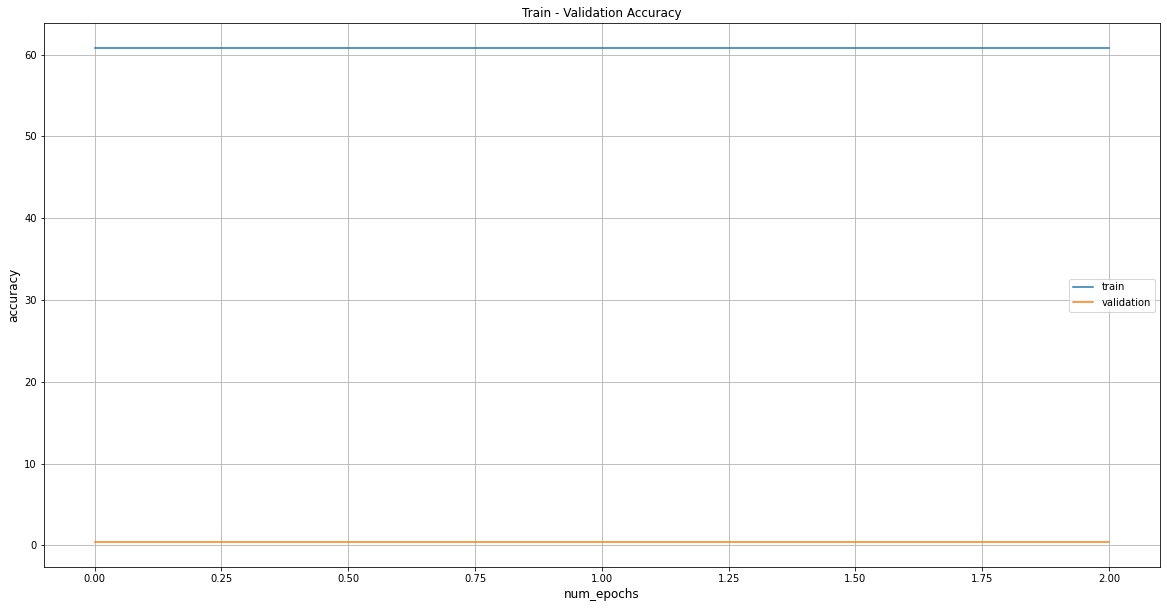

test acc: 0.38989161834017505
TRAIN dates: 2021-01-01 02:06:52 - 2021-02-21 17:26:00  TEST dates: 2021-03-17 09:20:00 - 2021-04-29 06:44:05


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1

Epoch [1/12], Step [0/470], Loss: 0.5534
Epoch [1/12], Step [20/470], Loss: 0.8514
Epoch [1/12], Step [40/470], Loss: 0.9513
Epoch [1/12], Step [60/470], Loss: 0.5520
Epoch [1/12], Step [80/470], Loss: 0.5521
Epoch [1/12], Step [100/470], Loss: 1.5495
Epoch [1/12], Step [120/470], Loss: 1.3615
Epoch [1/12], Step [140/470], Loss: 1.5229
Epoch [1/12], Step [160/470], Loss: 0.5922
Epoch [1/12], Step [180/470], Loss: 0.8301
Epoch [1/12], Step [200/470], Loss: 1.2650
Epoch [1/12], Step [220/470], Loss: 1.2977
Epoch [1/12], Step [240/470], Loss: 1.3324
Epoch [1/12], Step [260/470], Loss: 1.5143
Epoch [1/12], Step [280/470], Loss: 0.6923
Epoch [1/12], Step [300/470], Loss: 1.4688
Epoch [1/12], Step [320/470], Loss: 0.9963
Epoch [1/12], Step [340/470], Loss: 0.9471
Epoch [1/12], Step [360/470], Loss: 1.3776
Epoch [1/12], Step [380/470], Loss: 1.1893
Epoch [1/12], Step [400/470], Loss: 1.2534
Epoch [1/12], Step [420/470], Loss: 1.4068
Epoch [1/12], Step [440/470], Loss: 1.1817
Epoch [1

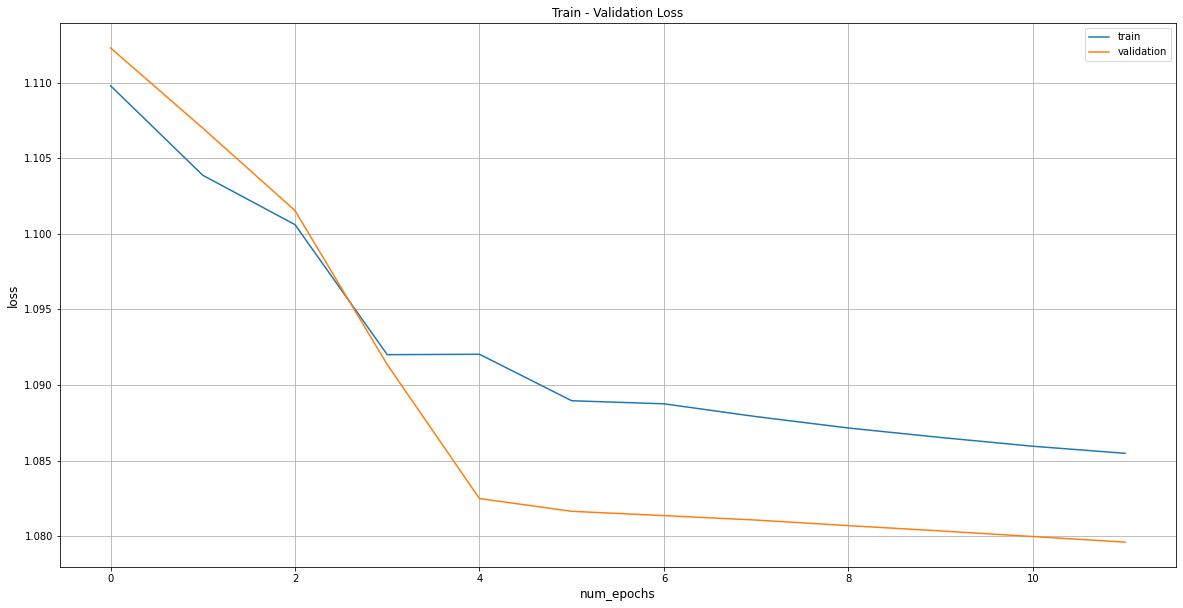

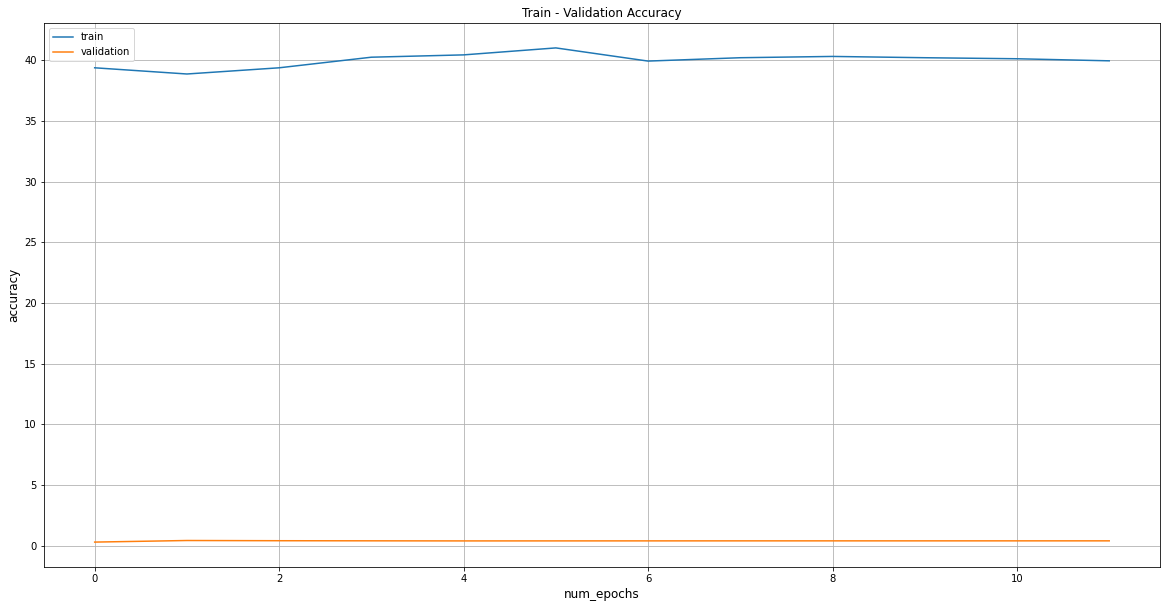

test acc: 0.41676323818082917
TRAIN dates: 2021-01-01 02:06:52 - 2021-03-27 11:33:00  TEST dates: 2021-04-29 06:44:05 - 2021-05-30 20:34:59


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1

Epoch [1/12], Step [0/846], Loss: 0.9851
Epoch [1/12], Step [20/846], Loss: 0.9682
Epoch [1/12], Step [40/846], Loss: 0.9523
Epoch [1/12], Step [60/846], Loss: 0.7722
Epoch [1/12], Step [80/846], Loss: 0.7439
Epoch [1/12], Step [100/846], Loss: 1.2969
Epoch [1/12], Step [120/846], Loss: 1.1664
Epoch [1/12], Step [140/846], Loss: 1.2905
Epoch [1/12], Step [160/846], Loss: 0.9863
Epoch [1/12], Step [180/846], Loss: 1.0799
Epoch [1/12], Step [200/846], Loss: 1.0998
Epoch [1/12], Step [220/846], Loss: 1.0259
Epoch [1/12], Step [240/846], Loss: 1.2210
Epoch [1/12], Step [260/846], Loss: 1.3185
Epoch [1/12], Step [280/846], Loss: 0.8649
Epoch [1/12], Step [300/846], Loss: 1.2991
Epoch [1/12], Step [320/846], Loss: 0.9884
Epoch [1/12], Step [340/846], Loss: 0.9556
Epoch [1/12], Step [360/846], Loss: 1.1223
Epoch [1/12], Step [380/846], Loss: 1.2215
Epoch [1/12], Step [400/846], Loss: 1.0862
Epoch [1/12], Step [420/846], Loss: 1.0805
Epoch [1/12], Step [440/846], Loss: 1.0888
Epoch [1

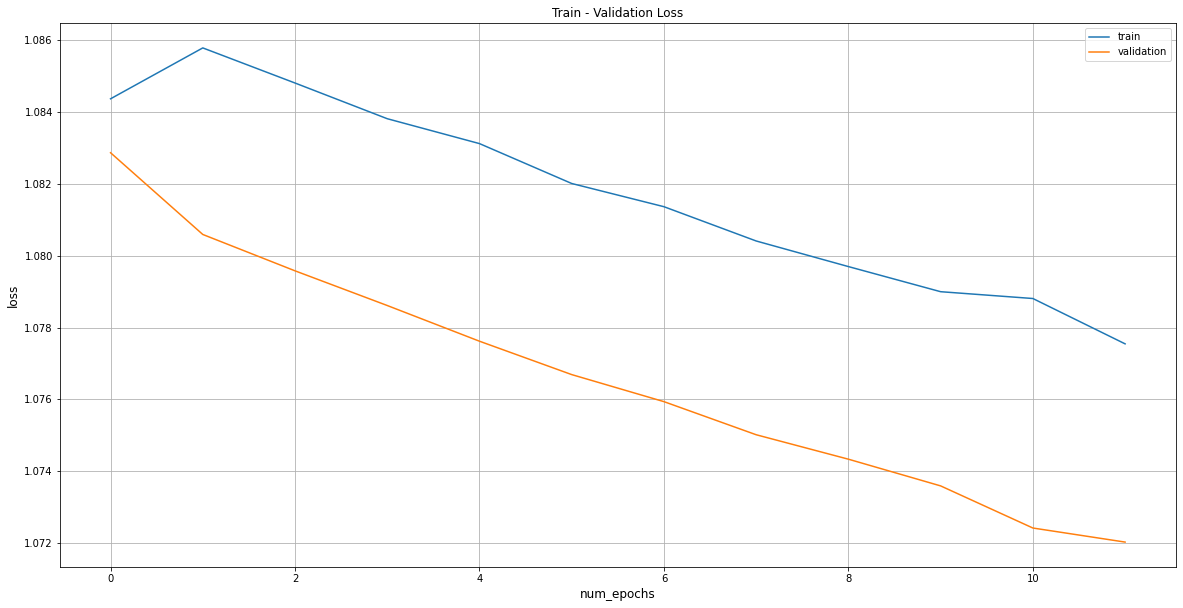

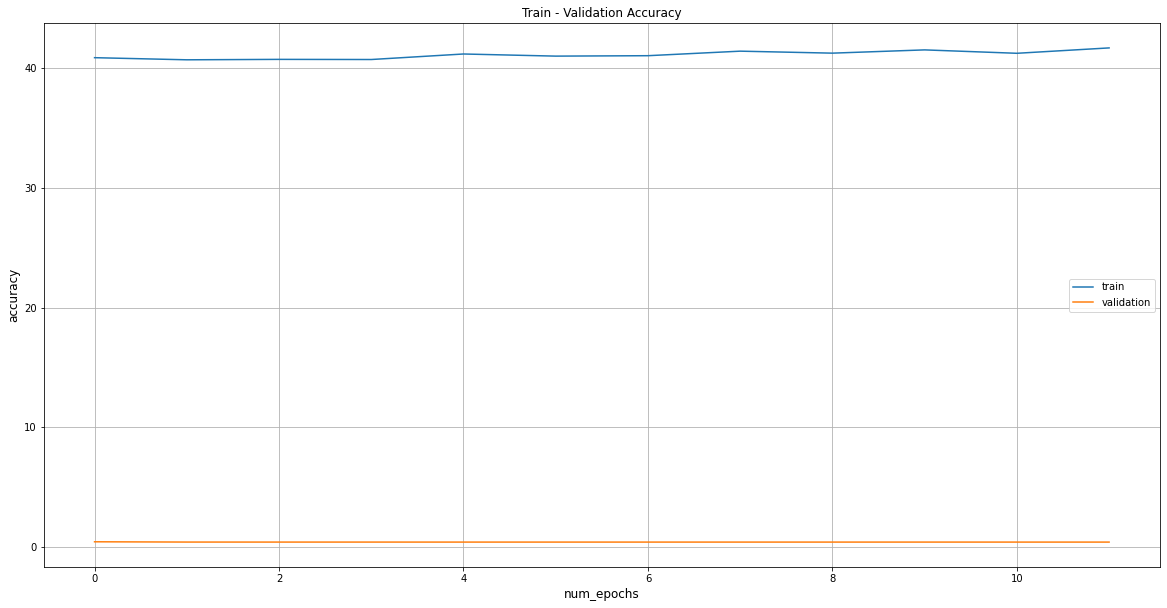

test acc: 0.4172204340151594
TRAIN dates: 2021-01-01 02:06:52 - 2021-05-10 13:58:00  TEST dates: 2021-05-30 20:34:59 - 2021-07-13 14:06:00


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1

Epoch [1/12], Step [0/1222], Loss: 0.9864
Epoch [1/12], Step [20/1222], Loss: 0.9700
Epoch [1/12], Step [40/1222], Loss: 0.9673
Epoch [1/12], Step [60/1222], Loss: 0.8447
Epoch [1/12], Step [80/1222], Loss: 0.8002
Epoch [1/12], Step [100/1222], Loss: 1.1809
Epoch [1/12], Step [120/1222], Loss: 1.1502
Epoch [1/12], Step [140/1222], Loss: 1.2530
Epoch [1/12], Step [160/1222], Loss: 0.8940
Epoch [1/12], Step [180/1222], Loss: 1.0949
Epoch [1/12], Step [200/1222], Loss: 1.1195
Epoch [1/12], Step [220/1222], Loss: 1.0436
Epoch [1/12], Step [240/1222], Loss: 1.1805
Epoch [1/12], Step [260/1222], Loss: 1.2656
Epoch [1/12], Step [280/1222], Loss: 0.8688
Epoch [1/12], Step [300/1222], Loss: 1.2824
Epoch [1/12], Step [320/1222], Loss: 0.9824
Epoch [1/12], Step [340/1222], Loss: 0.9134
Epoch [1/12], Step [360/1222], Loss: 1.1850
Epoch [1/12], Step [380/1222], Loss: 1.1868
Epoch [1/12], Step [400/1222], Loss: 1.1001
Epoch [1/12], Step [420/1222], Loss: 1.1310
Epoch [1/12], Step [440/1222]

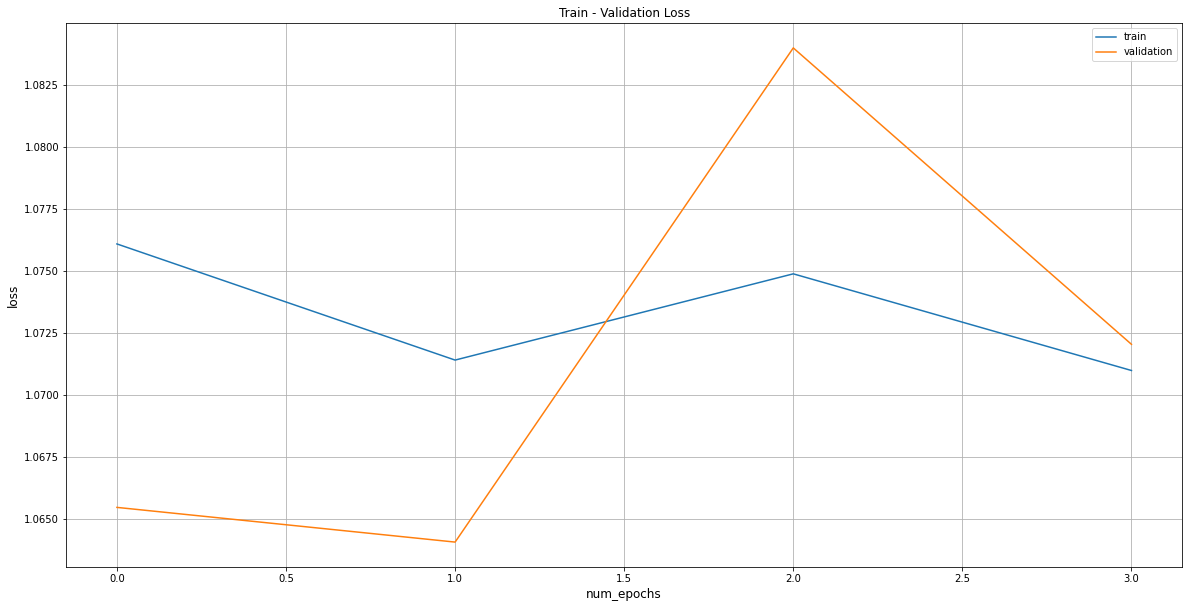

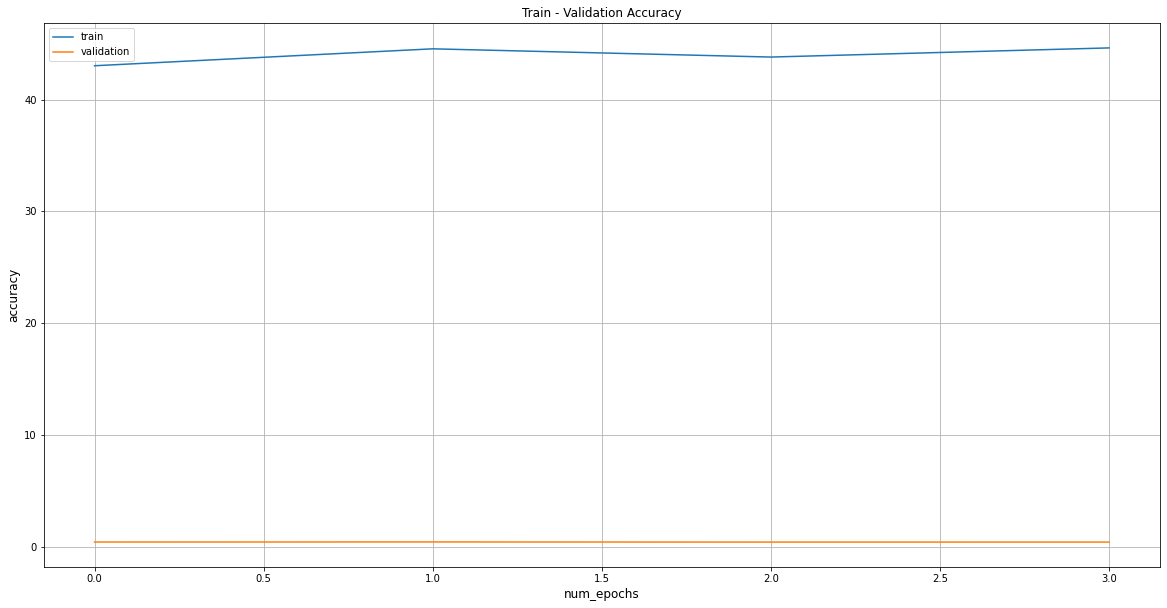

test acc: 0.4338721739630674
TRAIN dates: 2021-01-01 02:06:52 - 2021-06-11 06:00:04  TEST dates: 2021-07-13 14:06:00 - 2021-08-24 03:45:00


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1

Epoch [1/12], Step [0/1598], Loss: 0.7727
Epoch [1/12], Step [20/1598], Loss: 0.8823
Epoch [1/12], Step [40/1598], Loss: 0.9273
Epoch [1/12], Step [60/1598], Loss: 0.6498
Epoch [1/12], Step [80/1598], Loss: 0.6325
Epoch [1/12], Step [100/1598], Loss: 1.2907
Epoch [1/12], Step [120/1598], Loss: 1.2809
Epoch [1/12], Step [140/1598], Loss: 1.1948
Epoch [1/12], Step [160/1598], Loss: 0.9924
Epoch [1/12], Step [180/1598], Loss: 1.0558
Epoch [1/12], Step [200/1598], Loss: 1.2175
Epoch [1/12], Step [220/1598], Loss: 1.0324
Epoch [1/12], Step [240/1598], Loss: 1.1777
Epoch [1/12], Step [260/1598], Loss: 1.3197
Epoch [1/12], Step [280/1598], Loss: 0.8088
Epoch [1/12], Step [300/1598], Loss: 1.2889
Epoch [1/12], Step [320/1598], Loss: 0.9908
Epoch [1/12], Step [340/1598], Loss: 0.9719
Epoch [1/12], Step [360/1598], Loss: 1.0661
Epoch [1/12], Step [380/1598], Loss: 1.0993
Epoch [1/12], Step [400/1598], Loss: 1.0909
Epoch [1/12], Step [420/1598], Loss: 1.1102
Epoch [1/12], Step [440/1598]

In [ ]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=N_SPLITS, gap=int(GAP))
print(tscv)
acc = []
fold = 0

for train_index, test_index in tscv.split(features):
  torch.cuda.empty_cache()
  fold = fold + 1
  print(f"TRAIN dates: {features.iloc[train_index[0]].date} - {features.iloc[train_index[-1]].date}  TEST dates: {features.iloc[test_index[0]].date} - {features.iloc[test_index[-1]].date}") 
  
  train_split = int(train_index.shape[0]*0.8)  
  train = features.iloc[:train_split]
  val = features.iloc[train_split:]
  test = features.iloc[test_index]
  
  ss = StandardScaler()
  train[to_standardize] = ss.fit_transform(train[to_standardize])
  val[to_standardize] = ss.transform(val[to_standardize])
  test[to_standardize] = ss.transform(test[to_standardize])

  train.drop("date", axis=1, inplace=True) 
  train.drop(columns=["vola_label", "body_no_entities"]).astype("float64").values.shape
  train_ds = MyDataset(train)
  train_loader=DataLoader(train_ds, batch_size=10, shuffle=False)
  encoded = tokenizer(train.body_no_entities.to_list(), padding="max_length", truncation=True, return_tensors="pt")
  train_input_ids = DataLoader(encoded["input_ids"], batch_size=10, shuffle=False)
  train_attention_mask = DataLoader(encoded["attention_mask"], batch_size=10, shuffle=False)

  val.drop("date", axis=1, inplace=True) 
  val.drop(columns=["vola_label", "body_no_entities"]).astype("float64").values.shape
  val_ds = MyDataset(val)
  val_loader=DataLoader(val_ds, batch_size=10, shuffle=False)
  encoded_val = tokenizer(val.body_no_entities.to_list(), padding="max_length", truncation=True, return_tensors="pt")
  val_input_ids = DataLoader(encoded_val["input_ids"], batch_size=10, shuffle=False)
  val_attention_mask = DataLoader(encoded_val["attention_mask"], batch_size=10, shuffle=False)

  test.drop("date", axis=1, inplace=True) 
  test.drop(columns=["vola_label", "body_no_entities"]).astype("float64").values.shape
  test_ds = MyDataset(test)
  test_loader=DataLoader(test_ds, batch_size=10, shuffle=False)
  encoded_test = tokenizer(test.body_no_entities.to_list(), padding="max_length", truncation=True, return_tensors="pt")
  test_input_ids = DataLoader(encoded_test["input_ids"], batch_size=10, shuffle=False)
  test_attention_mask = DataLoader(encoded_test["attention_mask"], batch_size=10, shuffle=False)

  ########## Guarda los mejores checkpoints por val_loss y EarlyStopping aplicado a val_loss ##########
  n_epochs = 12
  print_every = 250
  valid_loss_min = np.Inf
  val_loss = []
  val_acc = []
  train_loss = []
  train_acc = []
  total_step = len(train_loader)
  early_stopping = True
  patience_epochs = 2
  patience_count = 0

  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(custom_model.parameters(), lr=2e-5, weight_decay=0.01)

  for epoch in range(1, n_epochs+1):
      running_loss = 0.0
      correct = 0
      total=0
      print(f'Epoch {epoch}\n')
      for batch_idx, data in enumerate(zip(train_input_ids, train_attention_mask, train_loader)):
          input_ids, attention_masks, extra_data = data
          input_ids = input_ids.to(device)
          attention_masks = attention_masks.to(device)
          extra_data_feat, extra_data_labels = extra_data
          extra_data_feat = extra_data_feat.to(device)
          extra_data_labels = extra_data_labels.type(torch.LongTensor)
          extra_data_labels = extra_data_labels[:,0].to(device)
          # zero the parameter gradients
          optimizer.zero_grad()
          # forward + backward + optimize
          outputs = custom_model(input_ids, extra_data_feat, attention_mask=attention_masks)
          loss = criterion(outputs, extra_data_labels)
          loss.backward()
          optimizer.step()
          # print statistics
          running_loss += loss.item()
          _,pred = torch.max(outputs, dim=1)
          correct += torch.sum(pred==extra_data_labels).item()
          total += extra_data_labels.size(0)
          if (batch_idx) % print_every == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
      train_acc.append(correct / total)
      train_loss.append(running_loss/total_step)
      print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(correct / total):.4f}')
      batch_loss = 0
      total_t=0
      correct_t=0
      with torch.no_grad():
          custom_model.eval()
          for data_val in zip(val_input_ids, val_attention_mask, val_loader):
              input_ids_val, attention_masks_val, extra_data_val = data_val
              input_ids_val = input_ids_val.to(device)
              attention_masks_val = attention_masks_val.to(device)
              extra_data_feat_val, extra_data_labels_val = extra_data_val
              extra_data_feat_val = extra_data_feat_val.to(device)
              extra_data_labels_val = extra_data_labels_val.type(torch.LongTensor)
              extra_data_labels_val = extra_data_labels_val[:,0].to(device)
              outputs_val = custom_model(input_ids_val, extra_data_feat_val, attention_mask=attention_masks_val)
              loss_t = criterion(outputs_val, extra_data_labels_val)
              batch_loss += loss_t.item()
              _,pred_t = torch.max(outputs_val, dim=1)
              correct_t += torch.sum(pred_t==extra_data_labels_val).item()
              total_t += extra_data_labels_val.size(0)
          val_acc.append(correct_t / total_t)
          val_loss.append(batch_loss/len(val_loader))
          network_learned = batch_loss < valid_loss_min
          print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(correct_t / total_t):.4f}\n')
          # Saving the best weight 
          if network_learned:
              valid_loss_min = batch_loss
              torch.save(custom_model.state_dict(), 'vola_paragraph_pytorch.pt')
              print('Detected network improvement, saving current model')
              patience_count = 0
          else:
              patience_count += 1
              if patience_count >= patience_epochs and early_stopping:
                  break
      custom_model.train()

  fig = plt.figure(figsize=(20,10))
  plt.title("Train - Validation Loss")
  plt.plot(train_loss, label='train')
  plt.plot(val_loss, label='validation')
  plt.xlabel('num_epochs', fontsize=12)
  plt.ylabel('loss', fontsize=12)
  plt.legend(loc='best')
  plt.grid()
  plt.show()

  fig = plt.figure(figsize=(20,10))
  plt.title("Train - Validation Accuracy")
  plt.plot(train_acc, label='train')
  plt.plot(val_acc, label='validation')
  plt.xlabel('num_epochs', fontsize=12)
  plt.ylabel('accuracy', fontsize=12)
  plt.legend(loc='best')
  plt.grid()
  plt.show()

  with torch.no_grad():
    custom_model.eval()
    for data_test in zip(test_input_ids, test_attention_mask, test_loader):
        input_ids_test, attention_masks_test, extra_data_test = data_test
        input_ids_test = input_ids_test.to(device)
        attention_masks_test = attention_masks_test.to(device)
        extra_data_feat_test, extra_data_labels_test = extra_data_test
        extra_data_feat_test = extra_data_feat_test.to(device)
        extra_data_labels_test = extra_data_labels_test.type(torch.LongTensor)
        extra_data_labels_test = extra_data_labels_test[:,0].to(device)
        outputs_test = custom_model(input_ids_test, extra_data_feat_test, attention_mask=attention_masks_test)
        loss_t = criterion(outputs_test, extra_data_labels_test)
        batch_loss += loss_t.item()
        _,pred_t = torch.max(outputs_test, dim=1)
        correct_t += torch.sum(pred_t==extra_data_labels_test).item()
        total_t += extra_data_labels_test.size(0)
    test_acc = correct_t / total_t
    print("test acc:", test_acc)